In [1]:
import pandas as pd
from pathlib import Path
path_to_processed_data = Path("../src/data/processed")
import jax.numpy as jnp
import jax
import numpy as np

from matplotlib import pyplot as plt


In [2]:
ts_ref = pd.read_csv(path_to_processed_data / "reference_predictions.csv")
ts_ref["date"] = pd.to_datetime(ts_ref["date"])
ts_ref["model"] = "historical"
ts_ref["bias_correction"] = "uncorrected"
ts_ref["duration"] = ts_ref["date"] - pd.Timestamp("1971-01-01")
ts_ref["month"] = ts_ref["date"].dt.month
ts_ref["year"] = ts_ref["date"].dt.year + 2069 - 1971
ts_ref.drop(["date"], axis=1, inplace=True)

ts_fut = pd.read_csv(path_to_processed_data / "future_projections.csv")
ts_fut["date"] = pd.to_datetime(ts_fut["date"])
ts_fut["duration"] = ts_fut["date"] - pd.Timestamp("2069-01-01")
ts_fut["month"] = ts_fut["date"].dt.month
ts_fut["year"] = ts_fut["date"].dt.year
ts_fut.drop(["date"], axis=1, inplace=True)

ts_all = pd.concat([ts_ref, ts_fut], ignore_index=True)

bias_corrections = ["uncorrected", "deltachange", "dbs"]
models = ts_all["model"].unique()
variables = ["t", "p", "q", "eact", "recharge"]
variable_units = {
    "q": "mm/day",
    "eact": "mm/day",
    "recharge": "mm/day",
    "p": "mm/day",
    "t": "°C"
}
variable_names = {
    "q": "discharge",
    "eact": "actual evapotranspiration",
    "recharge": "recharge",
    "p": "precipitation",
    "t": "temperature"
}

from itertools import cycle
linestyles_cycle = cycle(['-', '--', ':', '-.'])  # extend if needed
colors_cycle = cycle(plt.get_cmap('tab20').colors)  # any palette you like
method_to_ls = {m: next(linestyles_cycle) for m in bias_corrections}
model_to_c  = {m: next(colors_cycle) for m in models}


ts_all_peryear = ts_all.groupby(["bias_correction", "model", "year"]).agg({k:"mean" for k in variables})
ts_all_permonth = ts_all.groupby(["bias_correction", "model", "month"]).agg({k:"mean" for k in variables})

ts_all_peryear_min = ts_all.groupby(["bias_correction", "model", "year"]).agg({k:"min" for k in variables})
ts_all_peryear_min.index = ts_all_peryear_min.index.droplevel([-1])
ts_all_peryear_max = ts_all.groupby(["bias_correction", "model", "year"]).agg({k:"max" for k in variables})
ts_all_peryear_max.index = ts_all_peryear_max.index.droplevel([-1])

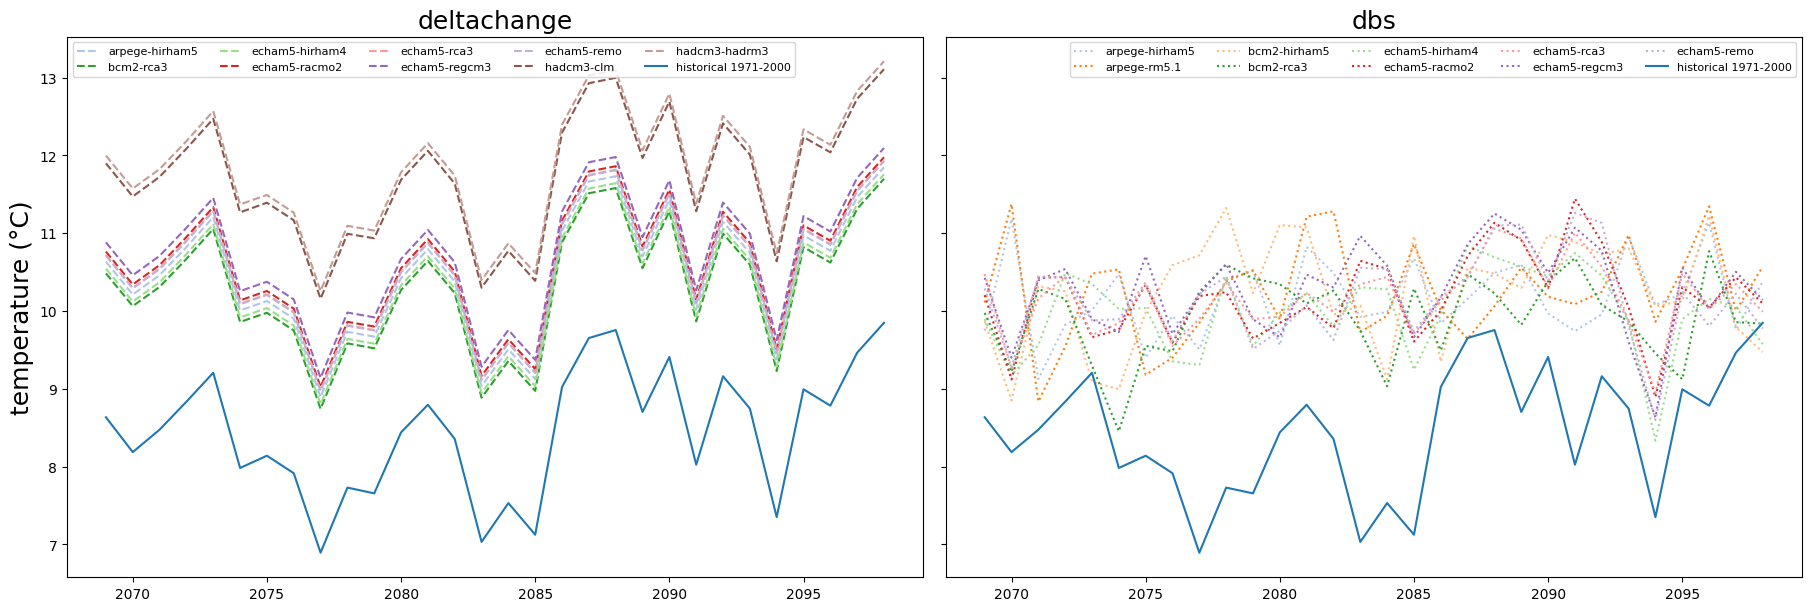

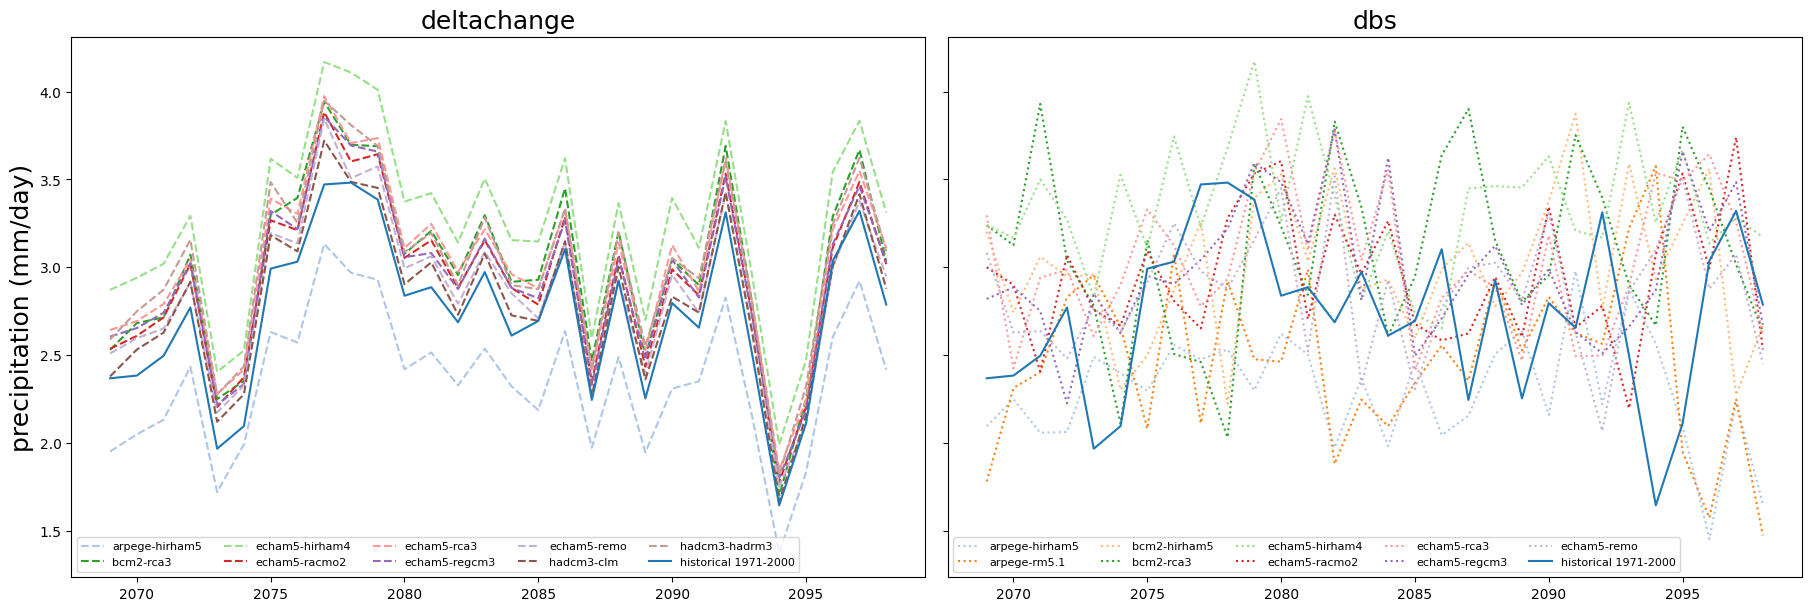

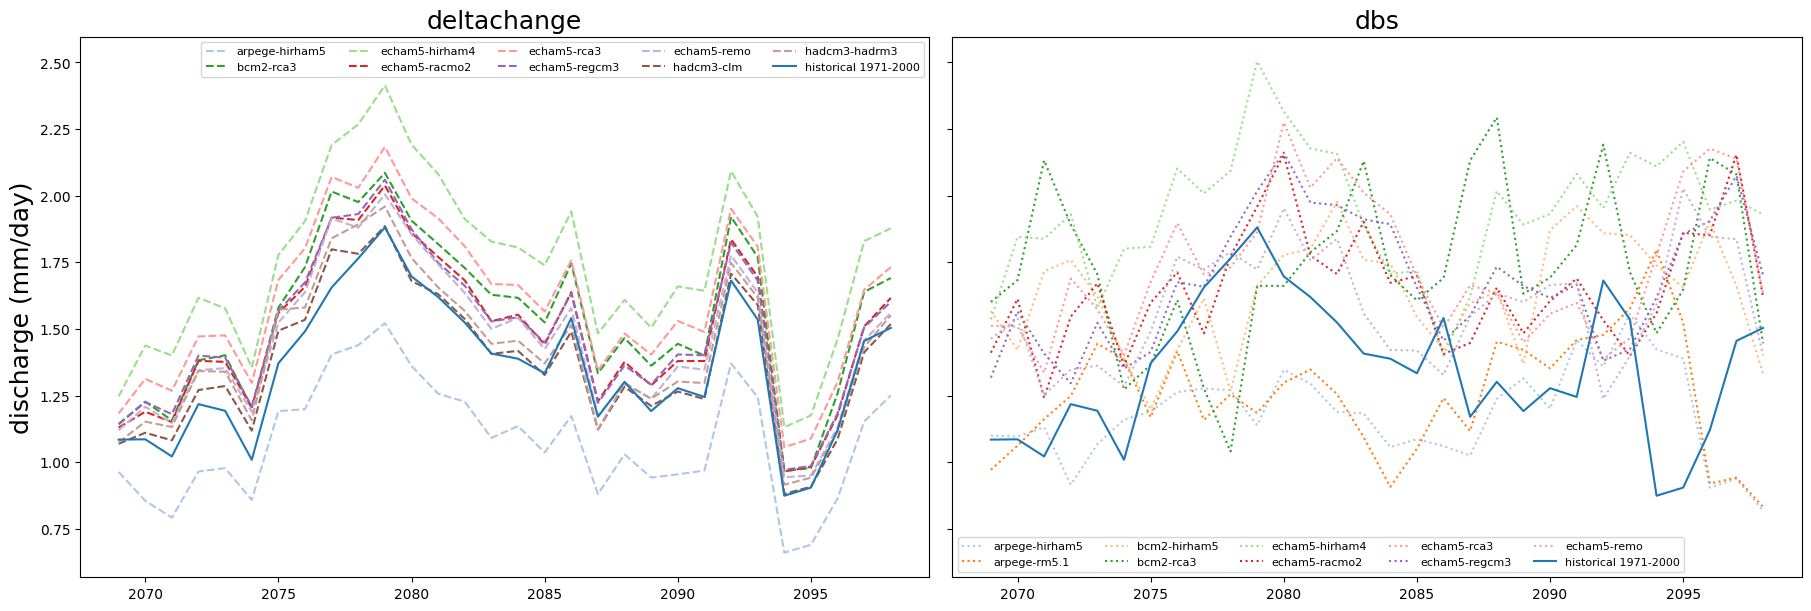

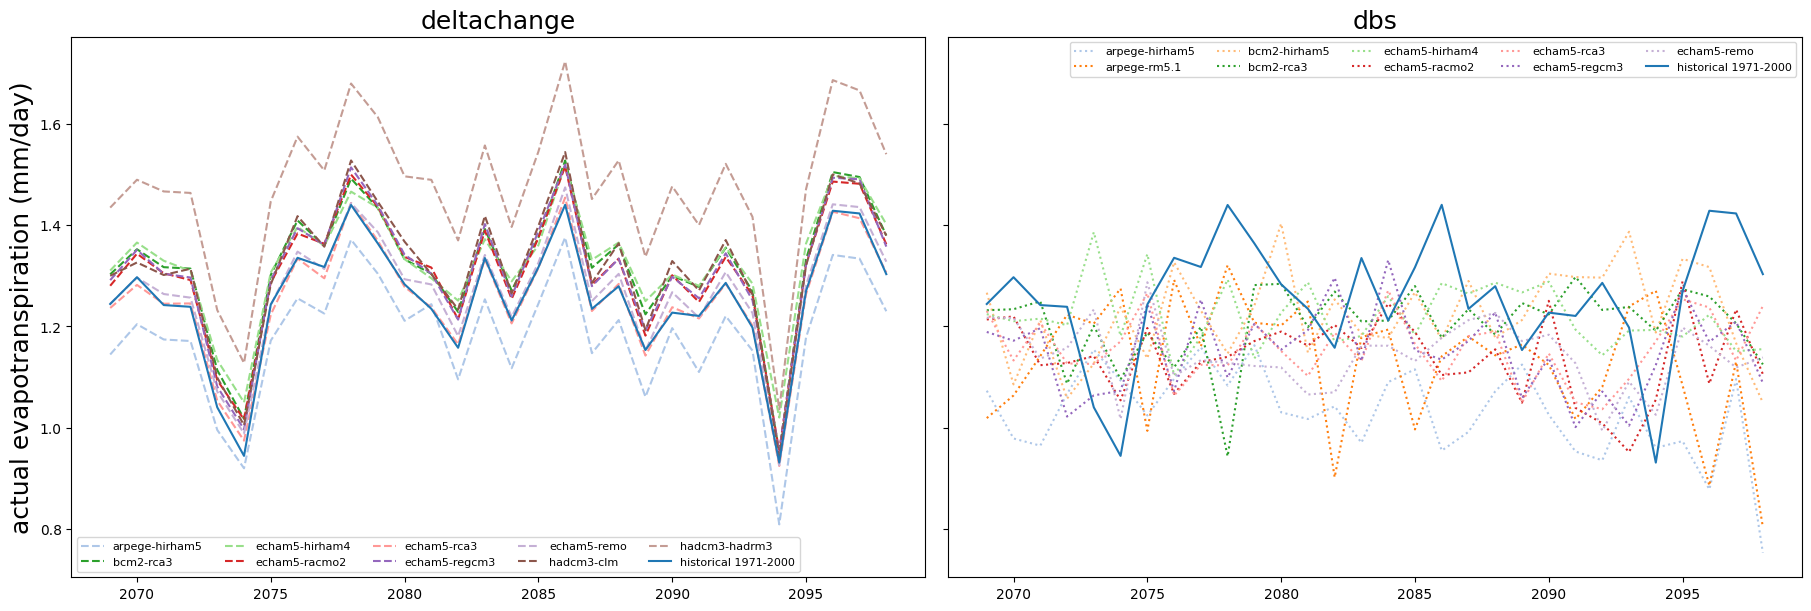

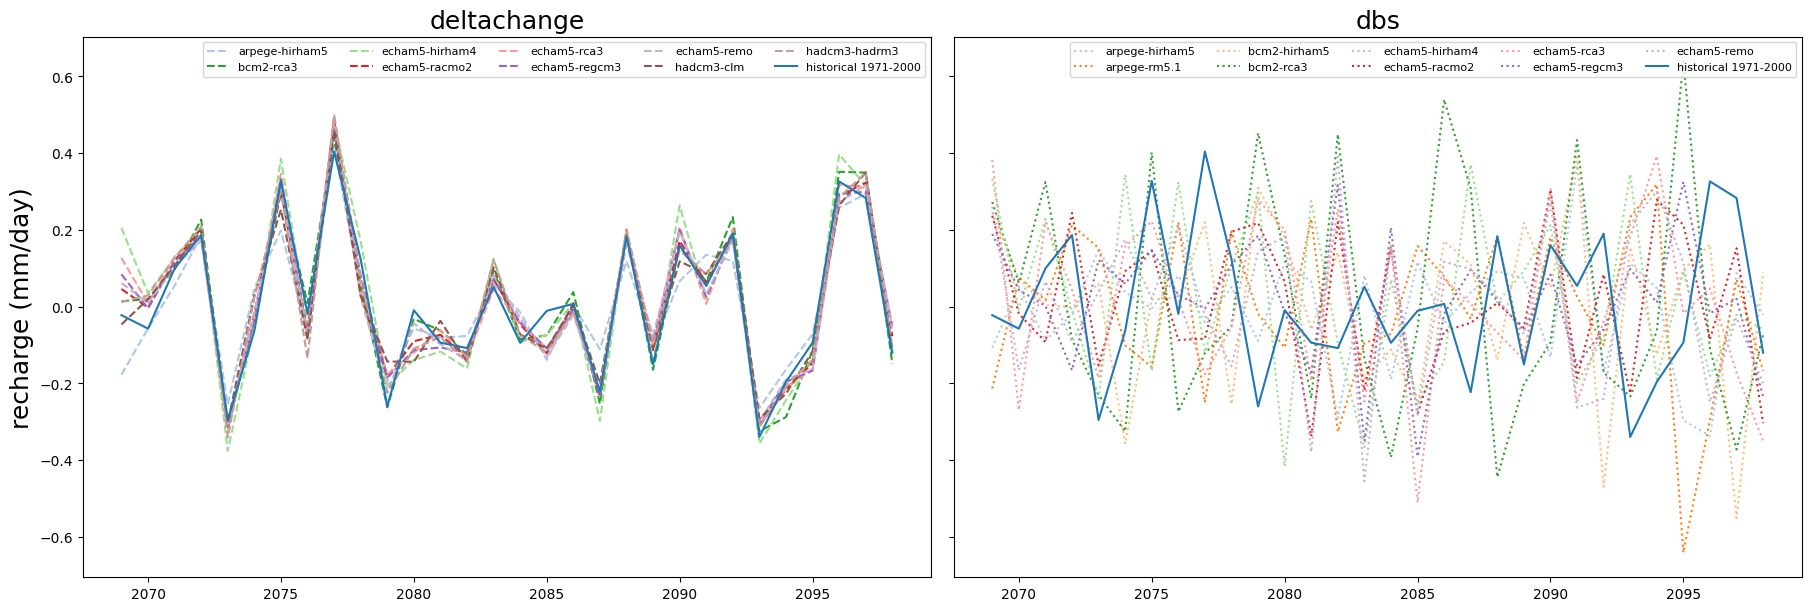

In [108]:
for v in variables:
    fig, axs = plt.subplots(figsize=(18,6), ncols=2, sharey=True, constrained_layout=True)
    for bias_correction, ax in zip(["deltachange", "dbs"], axs):
        for model in models:
            if (bias_correction, model) in ts_all_peryear.index:
                ax.plot(
                    ts_all_peryear.loc[(bias_correction, model),v],
                    label=f"{model}",
                    color=model_to_c[model],
                    linestyle=method_to_ls[bias_correction]
                )
        ax.plot(
            ts_all_peryear.loc[("uncorrected", "historical"),v],
            label="historical 1971-2000",
            color=model_to_c["historical"],
            linestyle=method_to_ls["uncorrected"]
        )
        ax.legend(ncols=5, fontsize=8)
        ax.set_title(f"{bias_correction}", fontsize=18)
    axs[0].set_ylabel(f"{variable_names[v]} ({variable_units[v]})", fontsize=18)
    fig.savefig(f"plots/future/annual_{v}.png")

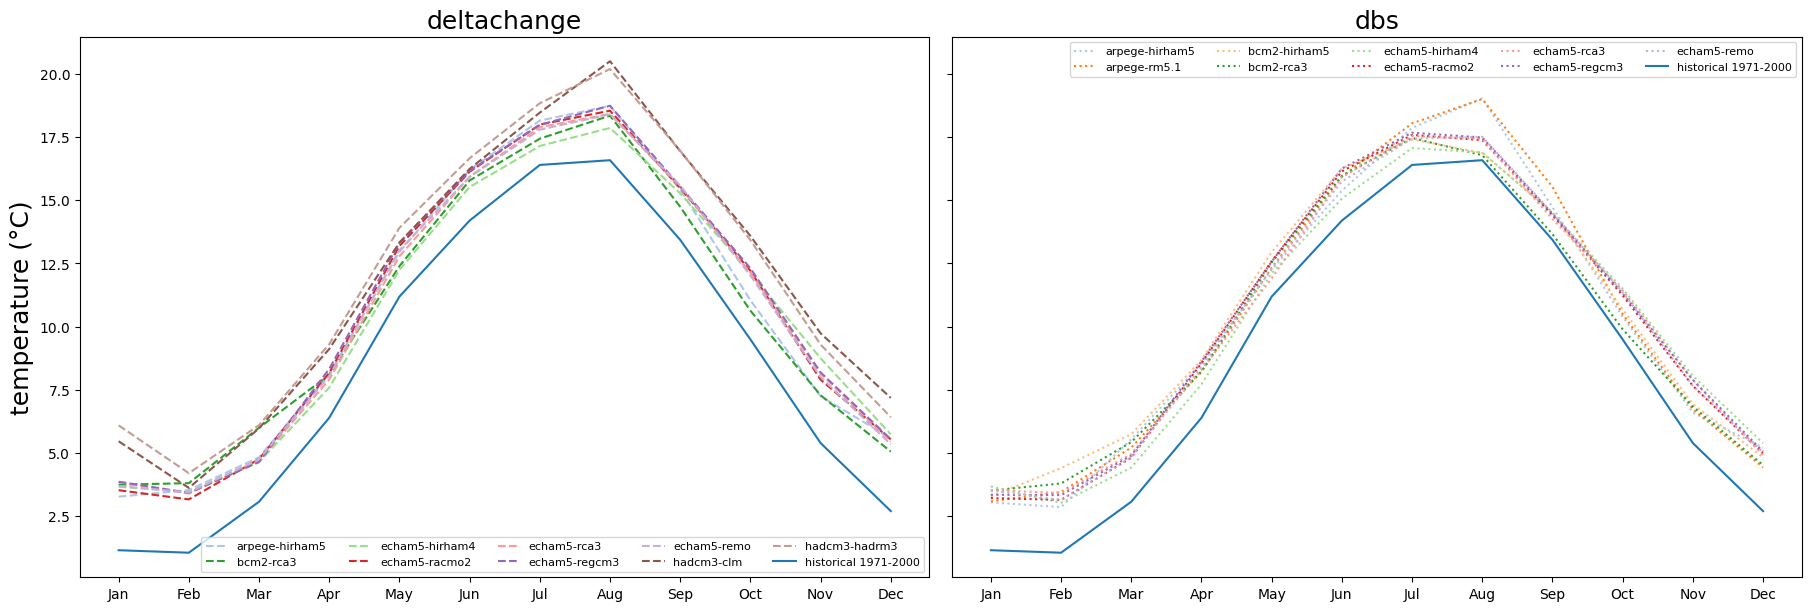

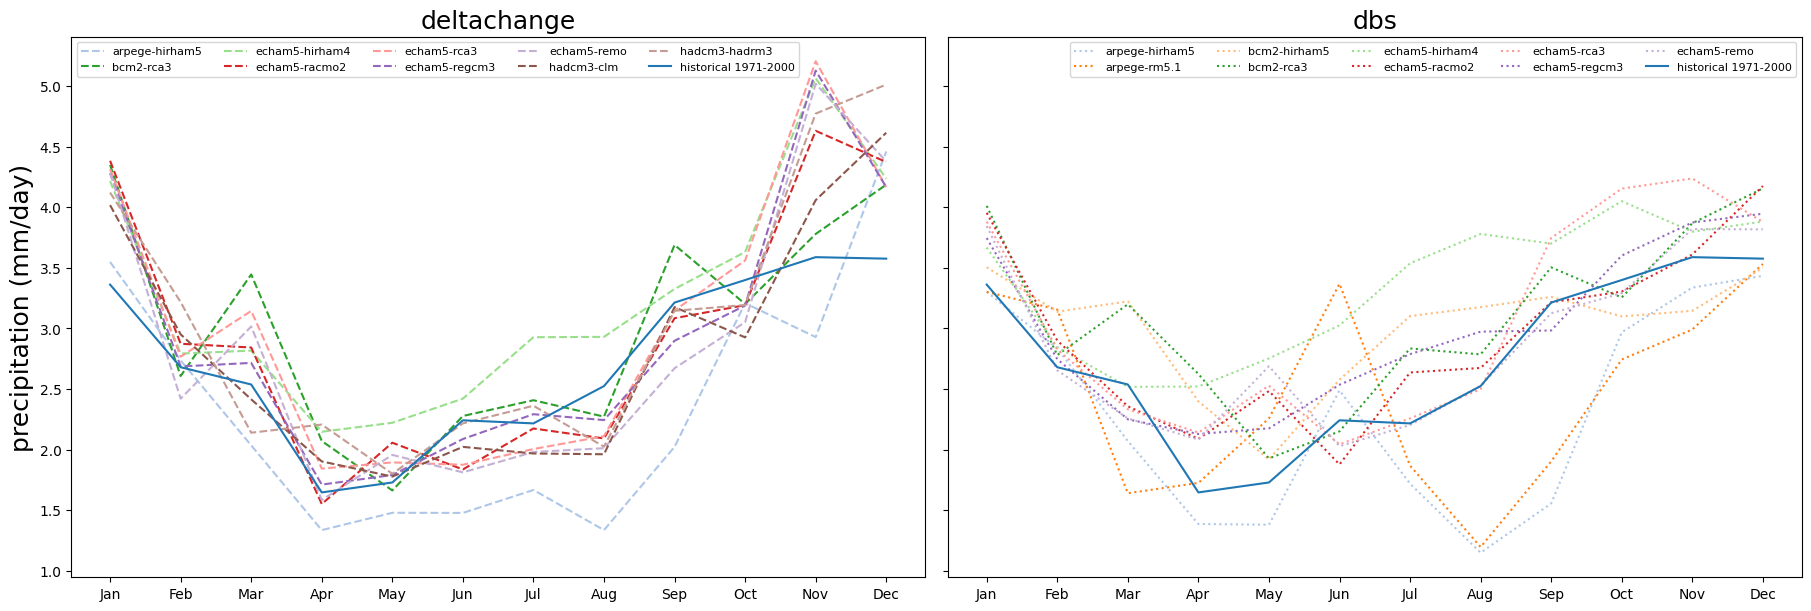

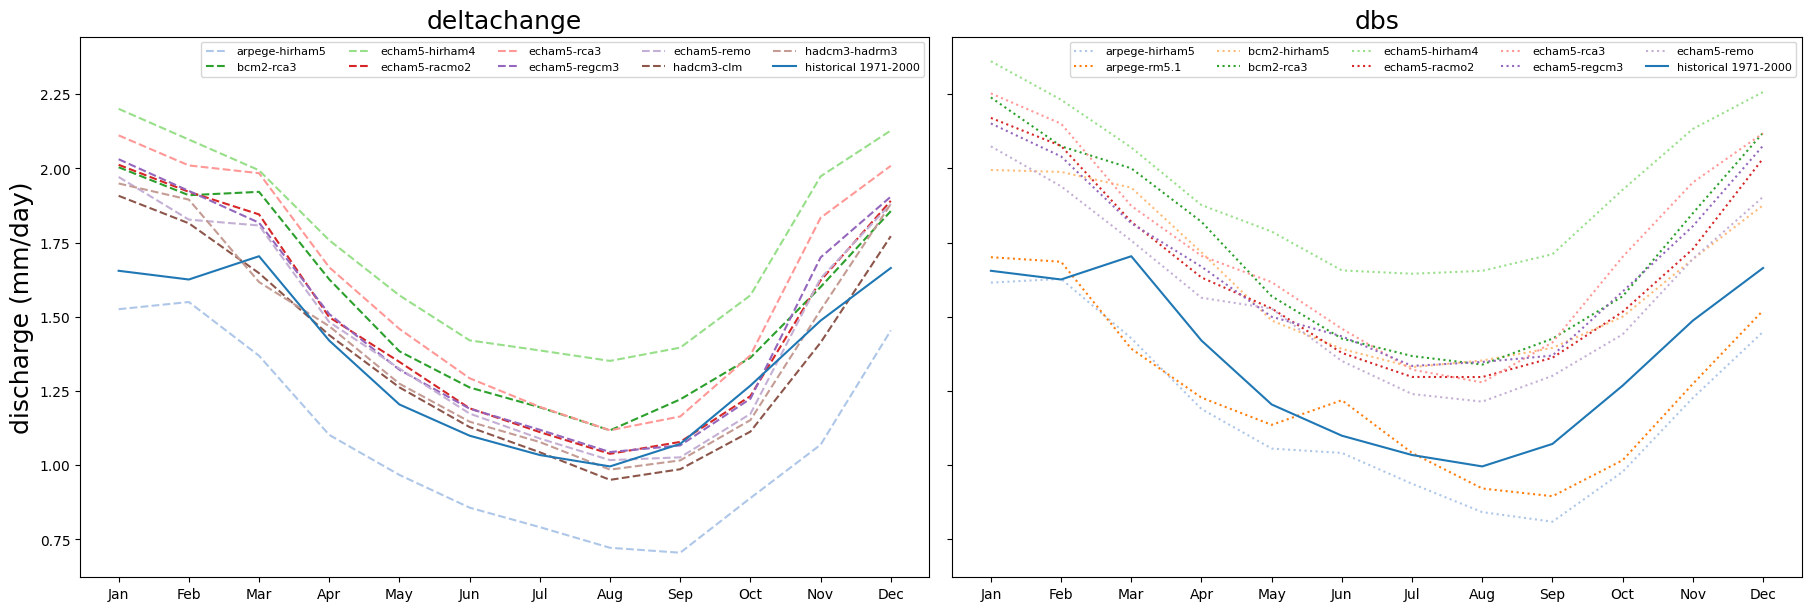

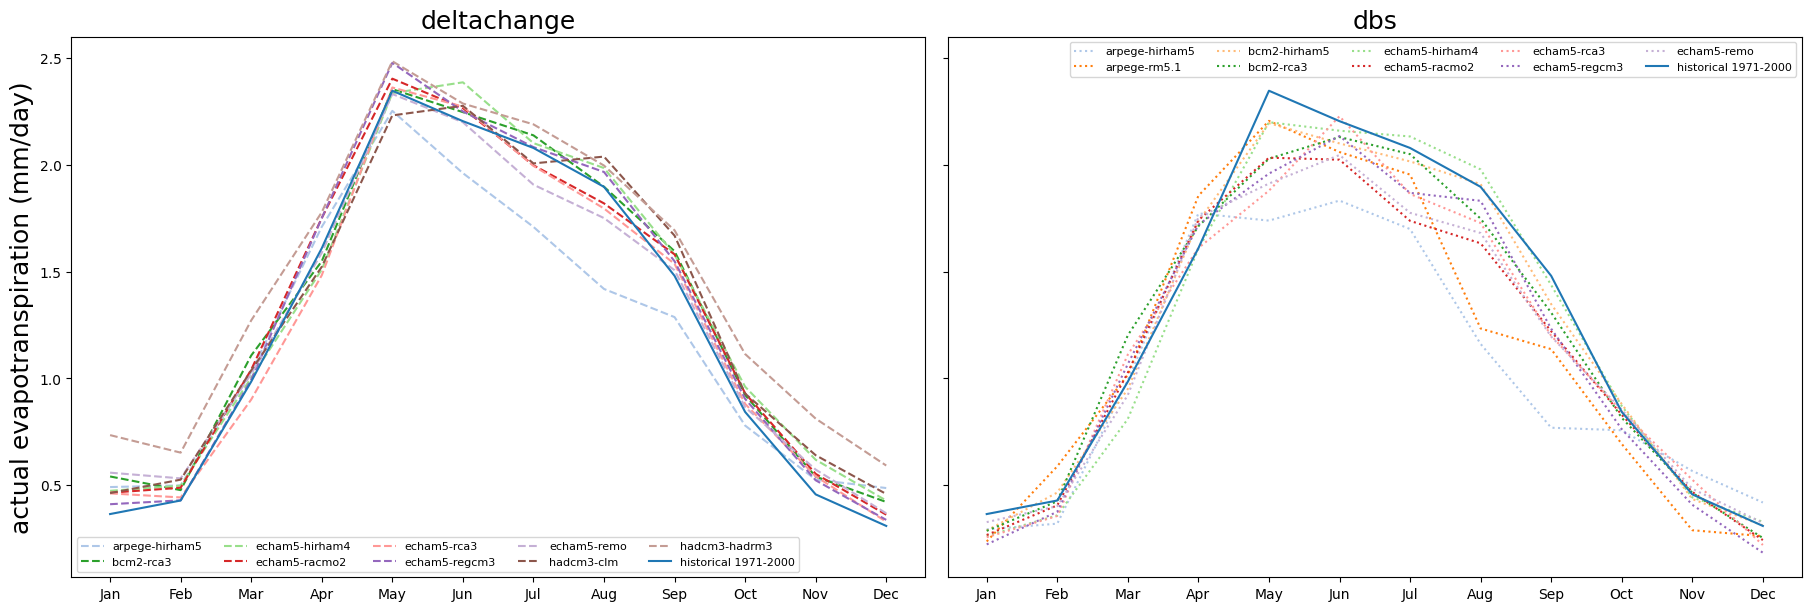

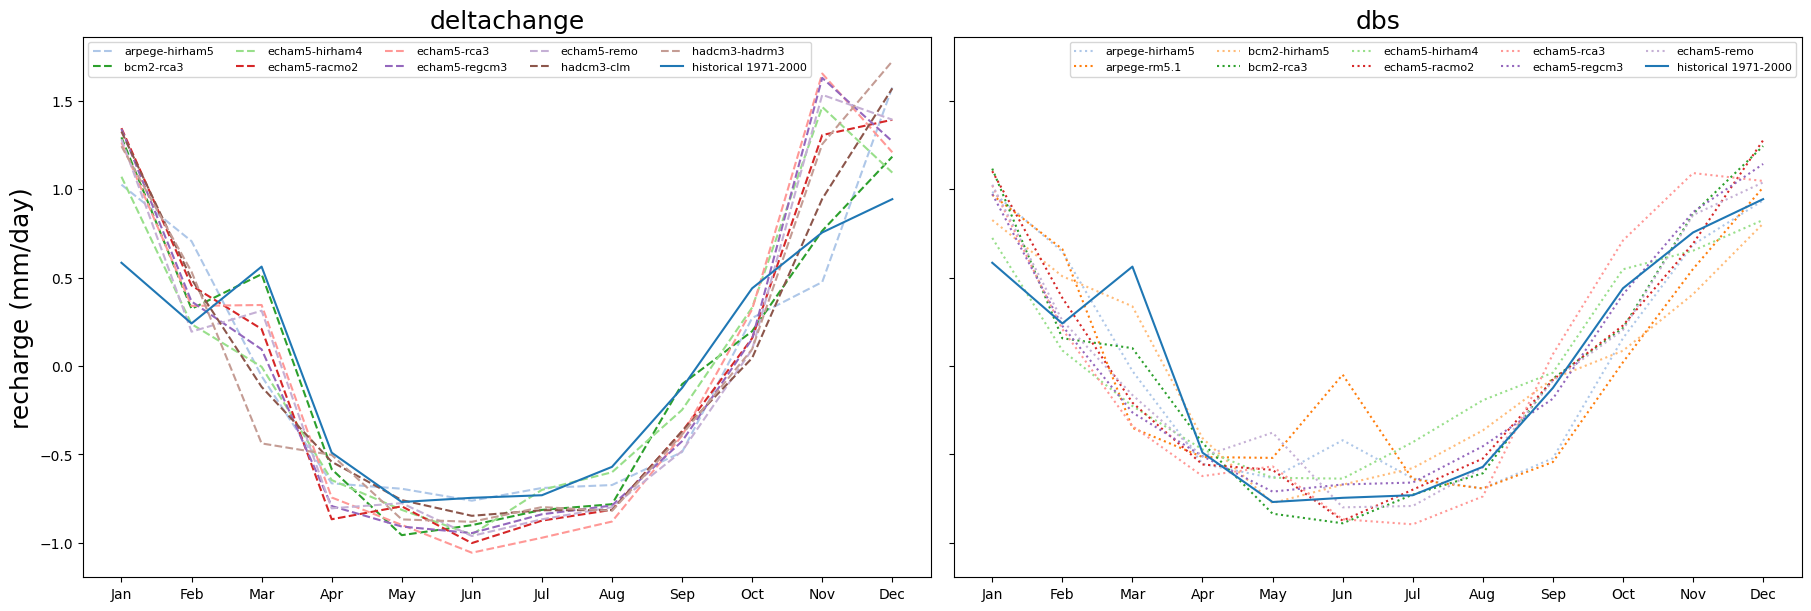

In [121]:
for v in variables:
    fig, axs = plt.subplots(figsize=(18,6), ncols=2, sharey=True, constrained_layout=True)
    for bias_correction, ax in zip(["deltachange", "dbs"], axs):
        for model in models:
            if (bias_correction, model) in ts_all_permonth.index:
                ax.plot(ts_all_permonth.loc[(bias_correction, model), v], label=f"{model}", color=model_to_c[model], linestyle=method_to_ls[bias_correction])
        ax.plot(ts_all_permonth.loc[("uncorrected", "historical"), v], label=f"historical 1971-2000", color=model_to_c["historical"], linestyle=method_to_ls["uncorrected"])
        ax.set_xticks(range(1,13))
        ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
        ax.legend(ncols=5, fontsize=8)
        ax.set_title(f"{bias_correction}", fontsize=18)
    axs[0].set_ylabel(f"{variable_names[v]} ({variable_units[v]})", fontsize=18)
    fig.savefig(f"plots/future/monthly_{v}.png")

In [3]:
def as_tree(df):
    melted = df.melt(ignore_index=False).set_index("variable", append=True)
    tree = {
        key: jnp.asarray(group["value"])
        for key, group in melted.groupby(level=[0,1,2])
    }
    return tree

from hydrosystem import evt_analysis

tree_max = as_tree(ts_all_peryear_max)
tree_min = as_tree(ts_all_peryear_min)

evt_max = jax.tree.map(lambda x: evt_analysis.gumbel_analysis(x, t=[50,100,200]), tree_max)
evt_min = jax.tree.map(lambda x: evt_analysis.gumbel_analysis(x, t=[50,100,200], minima=True), tree_min)

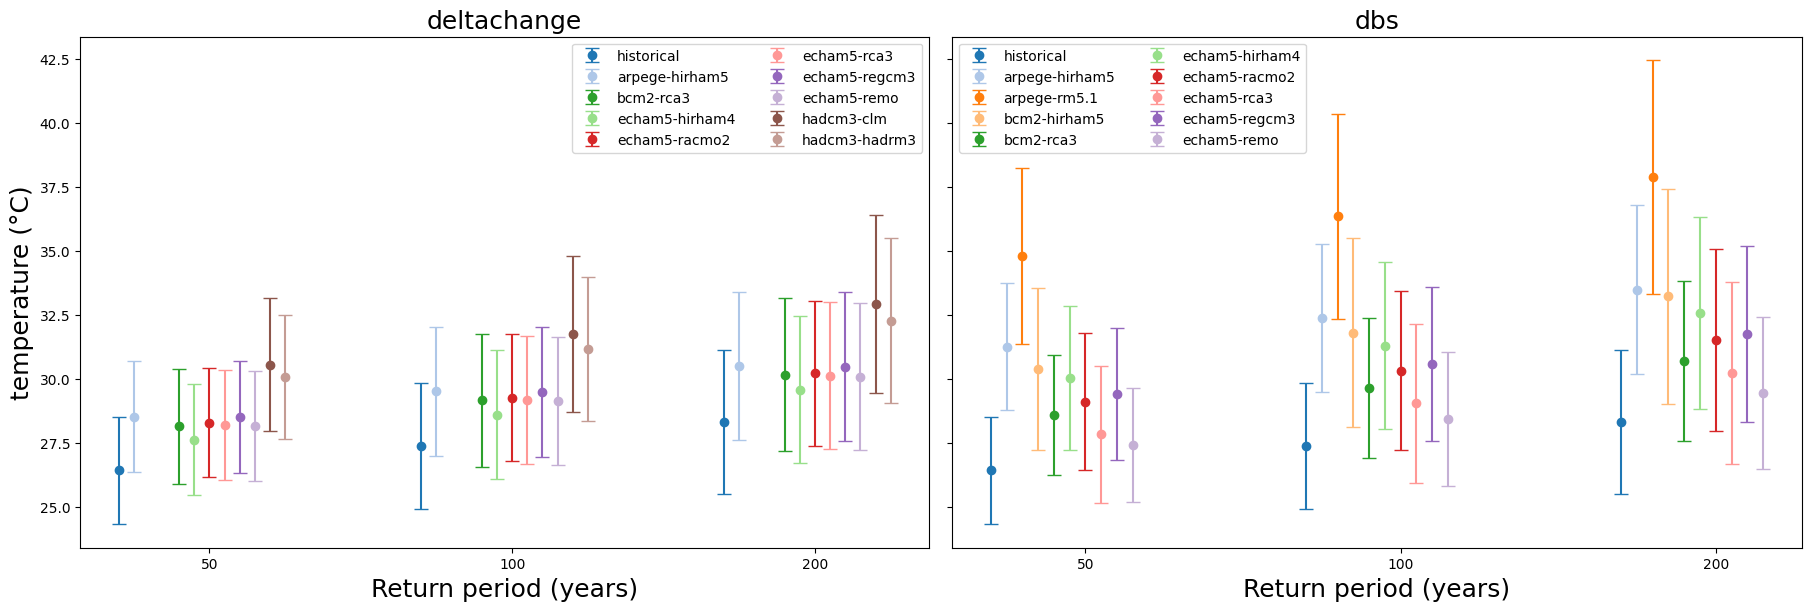

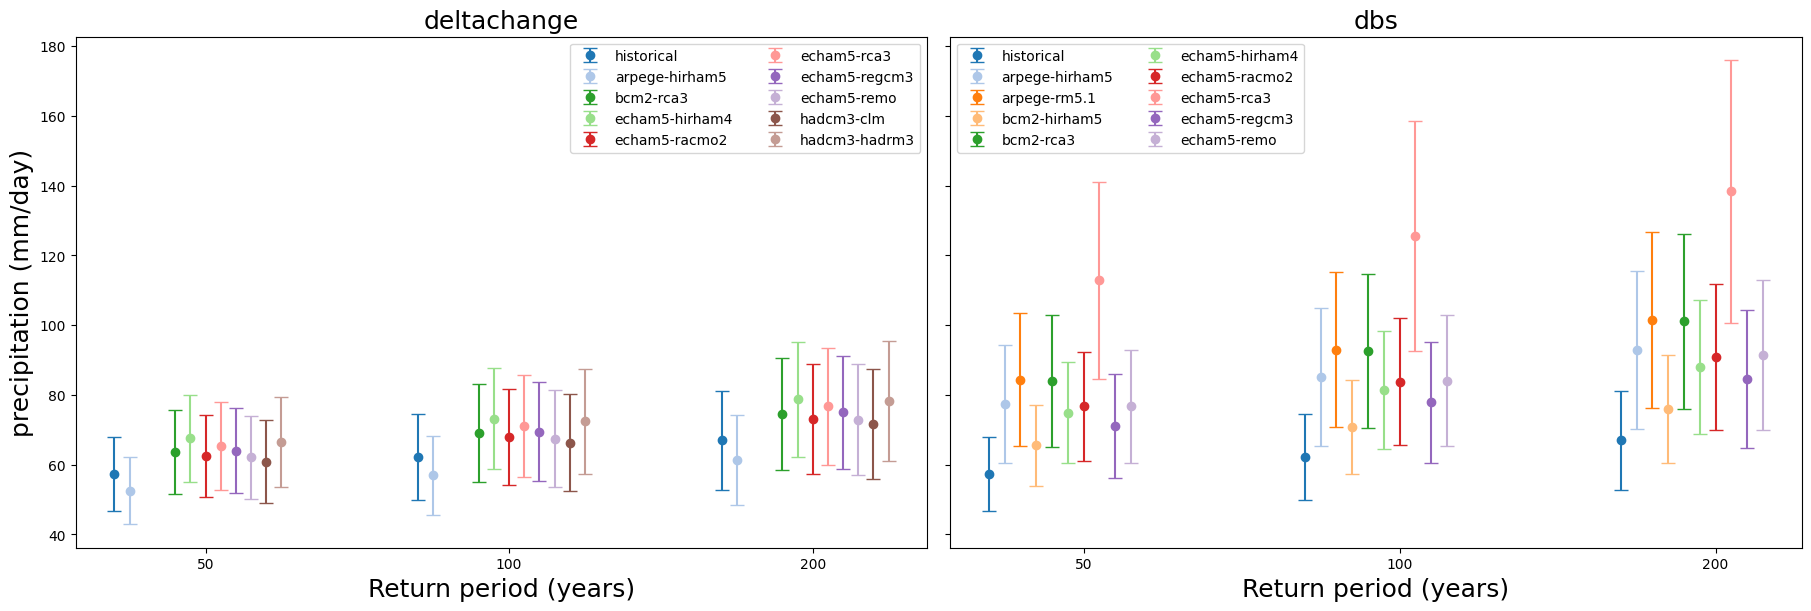

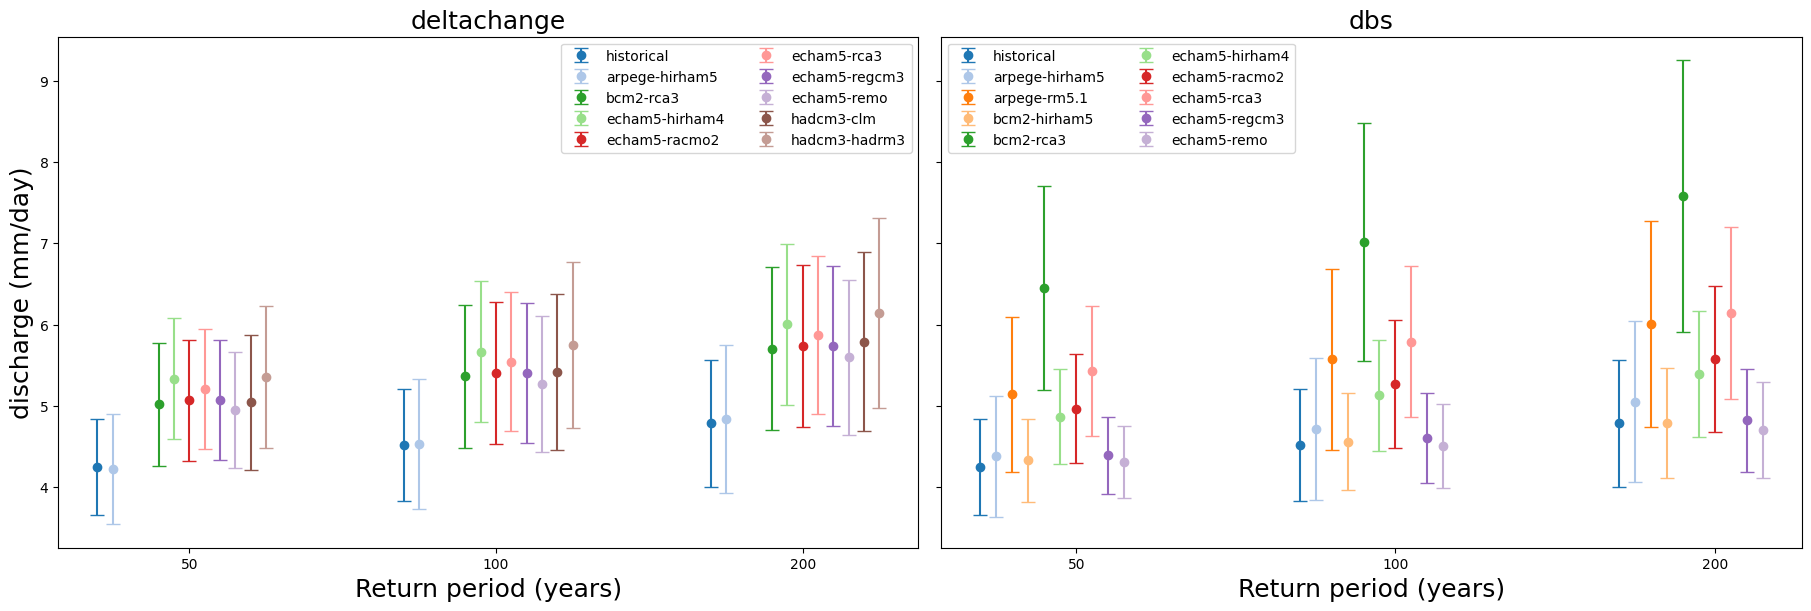

In [296]:
x = np.arange(3)  # base positions for categories
width = 0.05      # spacing between groups

for v in ["t", "p", "q"]:
    fig, axs = plt.subplots(figsize=(18,6), ncols=2, sharey=True, constrained_layout=True)
    axs[0].set_ylabel(f"{variable_names[v]} ({variable_units[v]})", fontsize=18)
    for bias_correction_, ax in zip(["deltachange", "dbs"], axs):
        for bias_correction in ["uncorrected", bias_correction_]:
            for i, model in enumerate(models):
                if (bias_correction, model, v) in tree_max:
                    obj = evt_max[(bias_correction, model, v)]
                    # Offset x positions for this model
                    x_positions = x + (i - len(models)/2) * width
                    ax.errorbar(x_positions, obj.event, yerr=1.96*obj.std,
                                fmt='o', capsize=5, label=model, color=model_to_c[model])

        ax.set_xlabel("Return period (years)", fontsize=18)
        ax.set_xticks(x)
        ax.set_xticklabels([50, 100, 200])
        ax.legend(ncols=2)
        ax.set_title(f"{bias_correction}", fontsize=18)
    fig.savefig(f"plots/future/evt_max_{v}.png")


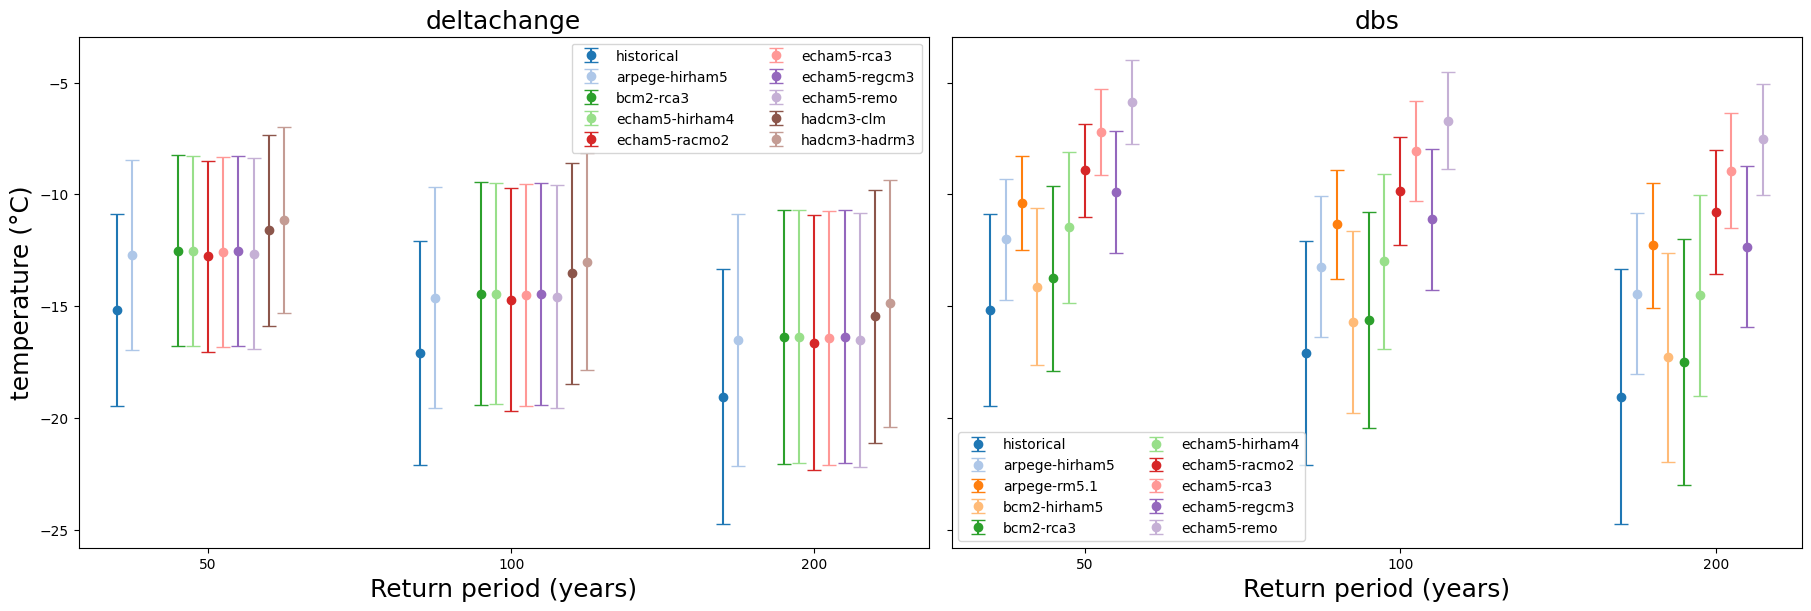

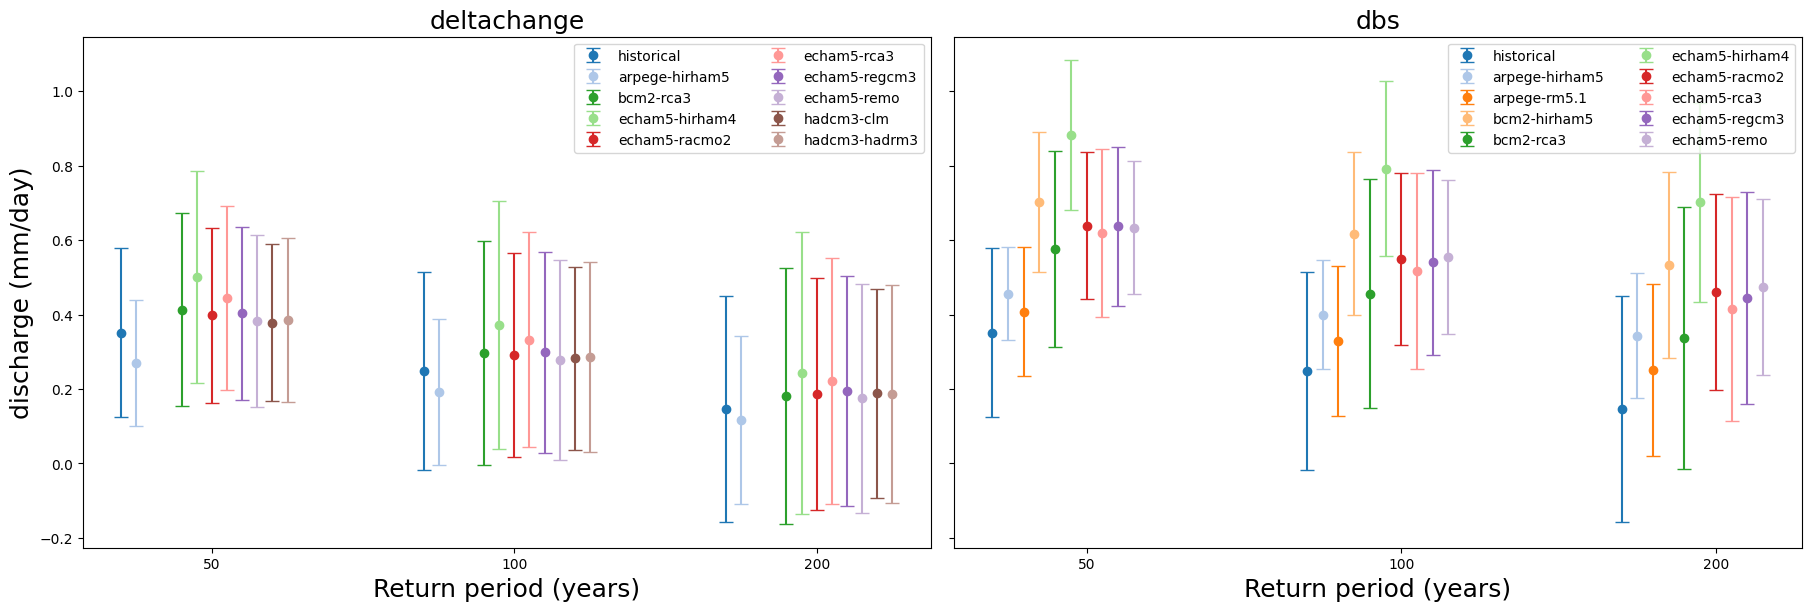

In [297]:
x = np.arange(3)  # base positions for categories
width = 0.05      # spacing between groups

for v in ["t", "q"]:
    fig, axs = plt.subplots(figsize=(18,6), ncols=2, sharey=True, constrained_layout=True)
    axs[0].set_ylabel(f"{variable_names[v]} ({variable_units[v]})", fontsize=18)
    for bias_correction_, ax in zip(["deltachange", "dbs"], axs):
        for bias_correction in ["uncorrected", bias_correction_]:
            for i, model in enumerate(models):
                if (bias_correction, model, v) in evt_min:
                    obj = evt_min[(bias_correction, model, v)]
                    # Offset x positions for this model
                    x_positions = x + (i - len(models)/2) * width
                    ax.errorbar(x_positions, obj.event, yerr=1.96*obj.std,
                                fmt='o', capsize=5, label=model, color=model_to_c[model])

        ax.set_xlabel("Return period (years)", fontsize=18)
        ax.set_xticks(x)
        ax.set_xticklabels([50, 100, 200])
        ax.legend(ncols=2)
        ax.set_title(f"{bias_correction}", fontsize=18)
    fig.savefig(f"plots/future/evt_min_{v}.png")


In [12]:
import scipy

def mean_diff_ttest(a,b):
    a,b = jnp.ravel(jnp.asarray(a)), jnp.ravel(jnp.asarray(b))
    t_score = (jnp.mean(a) - jnp.mean(b)) / jnp.sqrt(jnp.var(a)/a.shape[0] + jnp.var(b)/b.shape[0])
    df = a.shape[0] + b.shape[0] - 2
    p = 2*scipy.stats.t.sf(jnp.abs(t_score), df)
    return p

def mean_ci(x: jnp.ndarray, alpha: float = 0.95):
    x = jnp.asarray(x)
    interval = scipy.stats.t.interval(confidence=alpha, df=x.shape[0]-1, loc=jnp.mean(x), scale=jnp.std(x))
    return interval

In [7]:
scipy.stats.t.interval(0.95, df=5)

(np.float64(-2.570581835636314), np.float64(2.570581835636314))

In [5]:
mean_tree = as_tree(ts_all_peryear.droplevel(level=-1))

mean_diff_ttest(
    mean_tree[("dbs", "arpege-hirham5", "p")],
    mean_tree[("deltachange", "arpege-hirham5", "p")]
)

np.float64(0.5556449390737208)

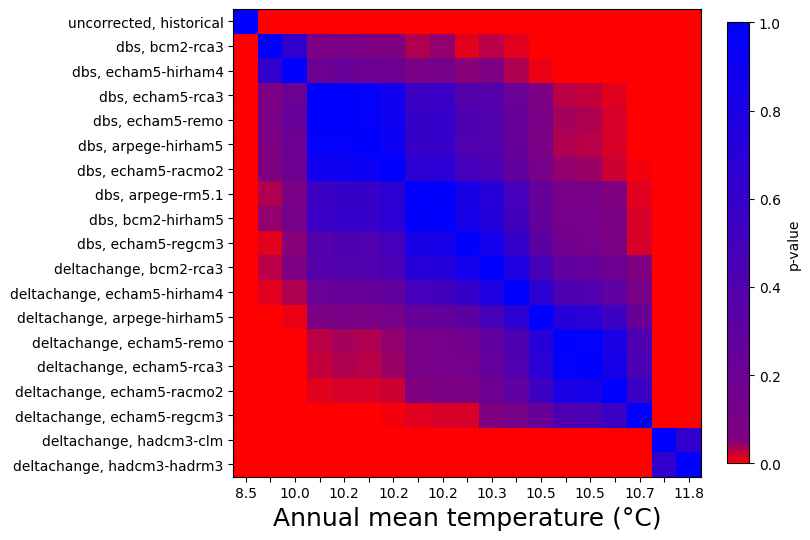

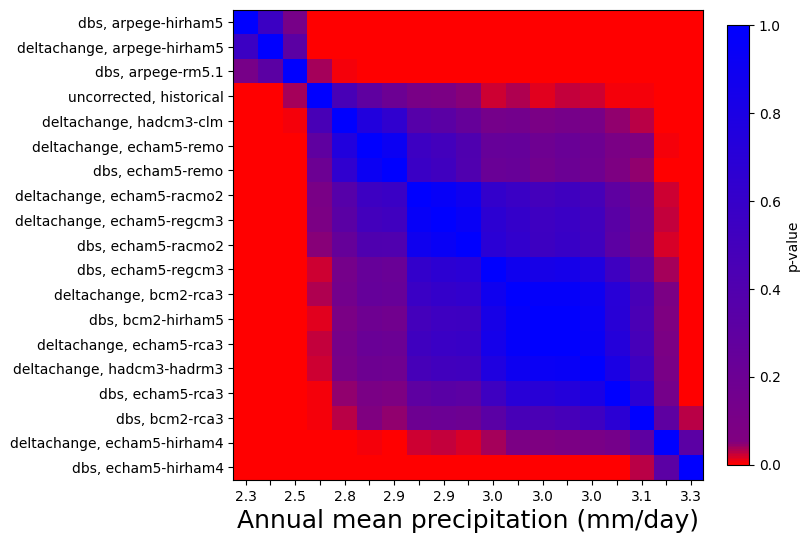

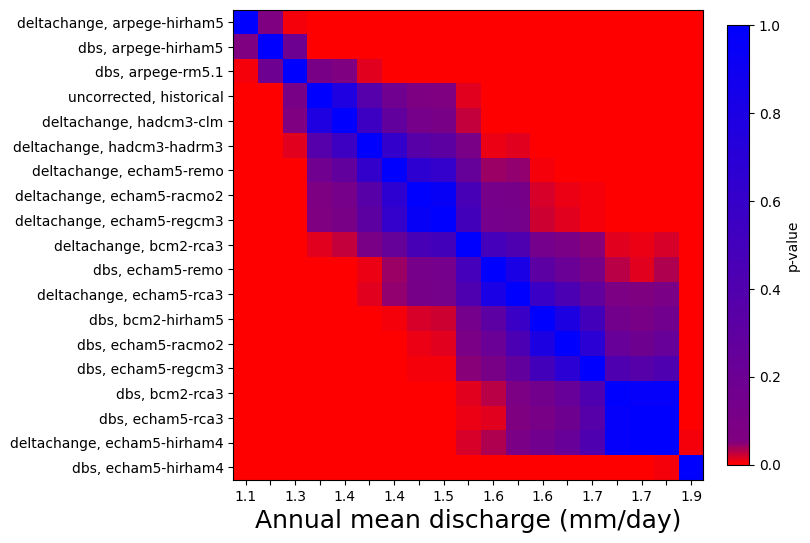

In [89]:
from matplotlib.colors import LinearSegmentedColormap

# Define colors for below and above threshold
colors = [
    (0.0, "red"),    # start (low p-values)
    (0.05, "purple"),  # transition at threshold
    (1.0, "blue")      # high p-values
]

for v in ["t", "p", "q"]:
    rel_keys = [k for k in mean_tree.keys() if k[-1] == v]
    means = [np.mean(mean_tree[k]) for k in rel_keys]
    sorted_keys = [rel_keys[i] for i in np.argsort(means)]
    sorted_means = np.array([means[i] for i in np.argsort(means)])
    results = np.zeros((len(rel_keys), len(rel_keys)))
    for i,key1 in enumerate(sorted_keys):
        for j,key2 in enumerate(sorted_keys):
            results[i,j] = mean_diff_ttest(
                mean_tree[key1],
                mean_tree[key2]
            )

    fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
    cb = ax.imshow(results, cmap=LinearSegmentedColormap.from_list("pval_cmap", colors))

    ax.set_xticks(np.arange(len(means))[::2])
    ax.set_xticklabels(np.round(sorted_means[::2],1))
    ax.set_xticks(np.arange(len(means)))
    ax.set_xlabel(f"Annual mean {variable_names[v]} ({variable_units[v]})", fontsize=18)

    ax.set_yticks(np.arange(len(rel_keys)))
    ax.set_yticklabels([f"{k[0]}, {k[1]}" for k in sorted_keys])

    fig.colorbar(cb, shrink=0.75, label="p-value")
    fig.savefig(f"plots/future/mean_diff_ttest_{v}.png")

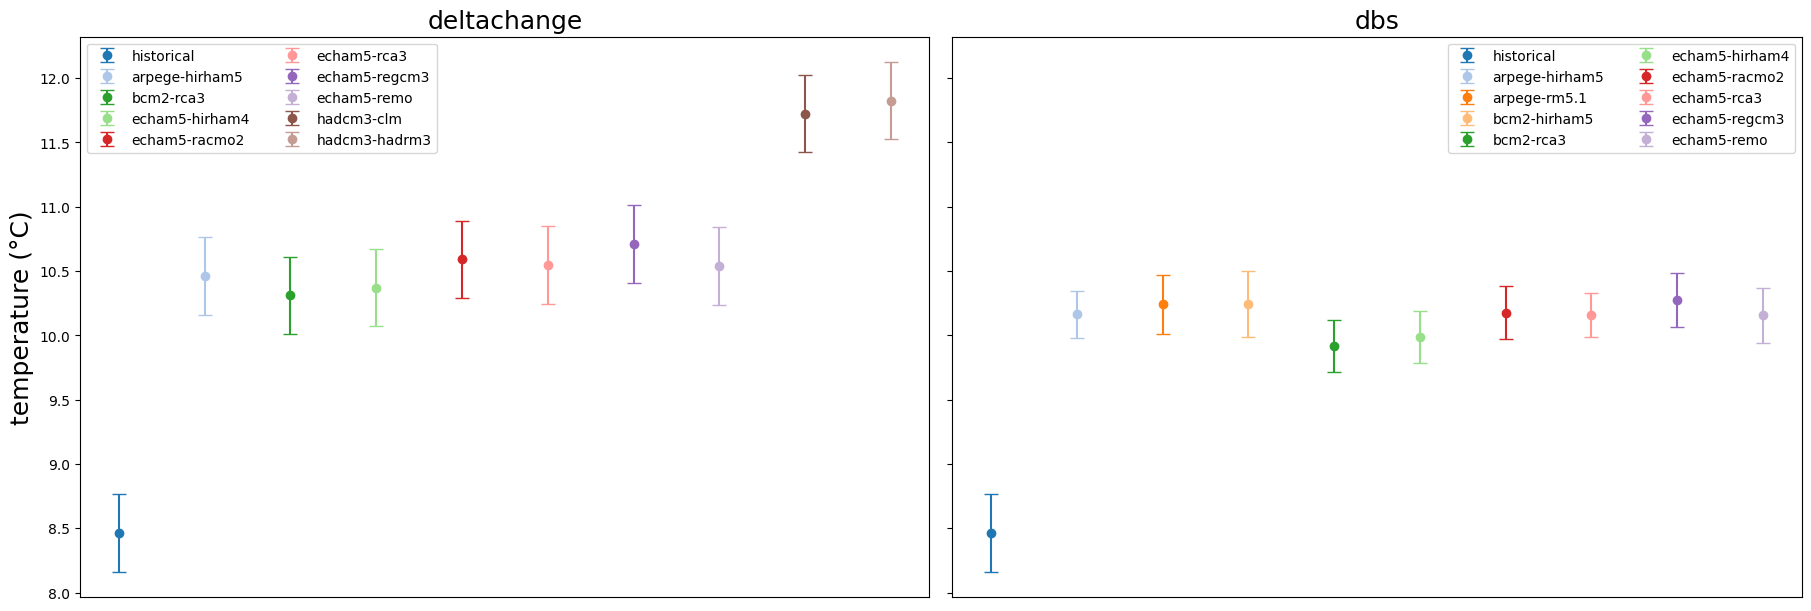

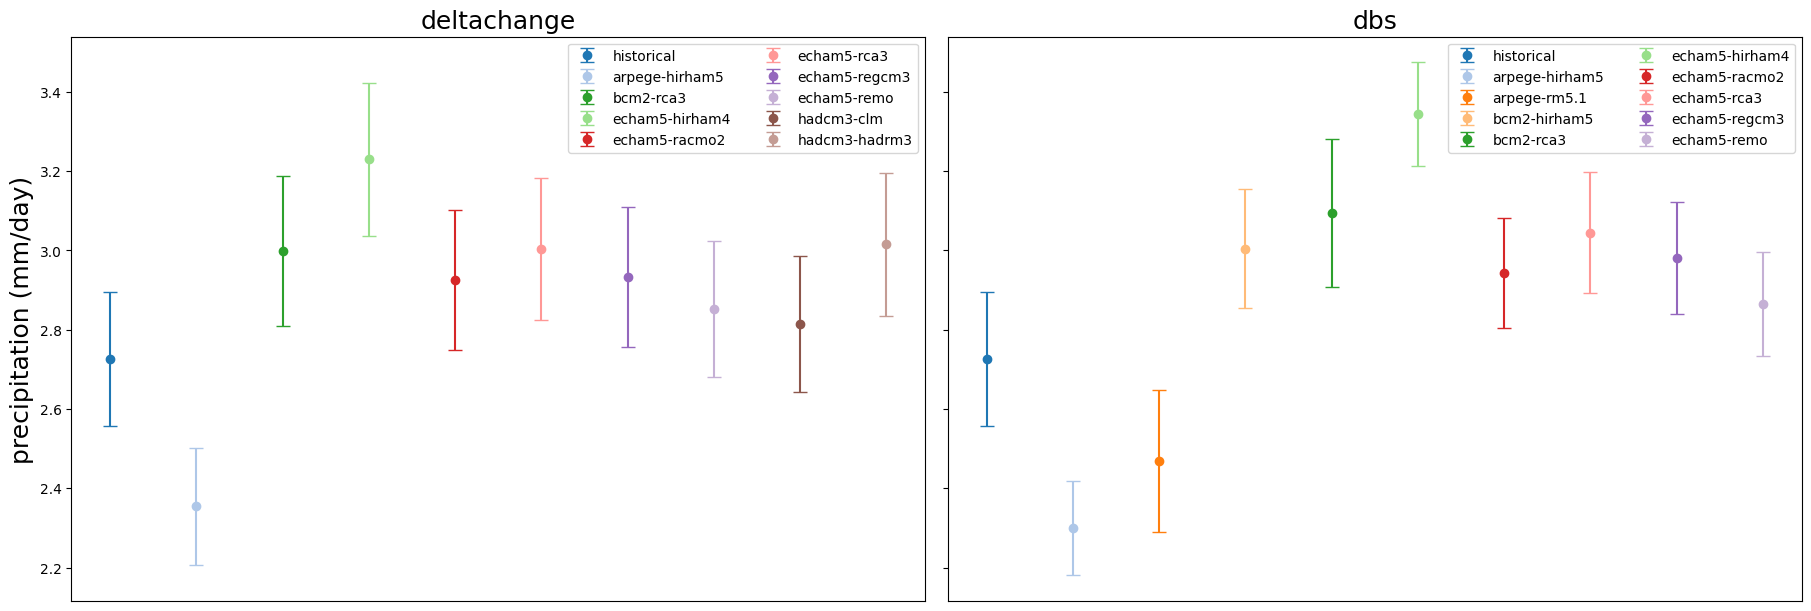

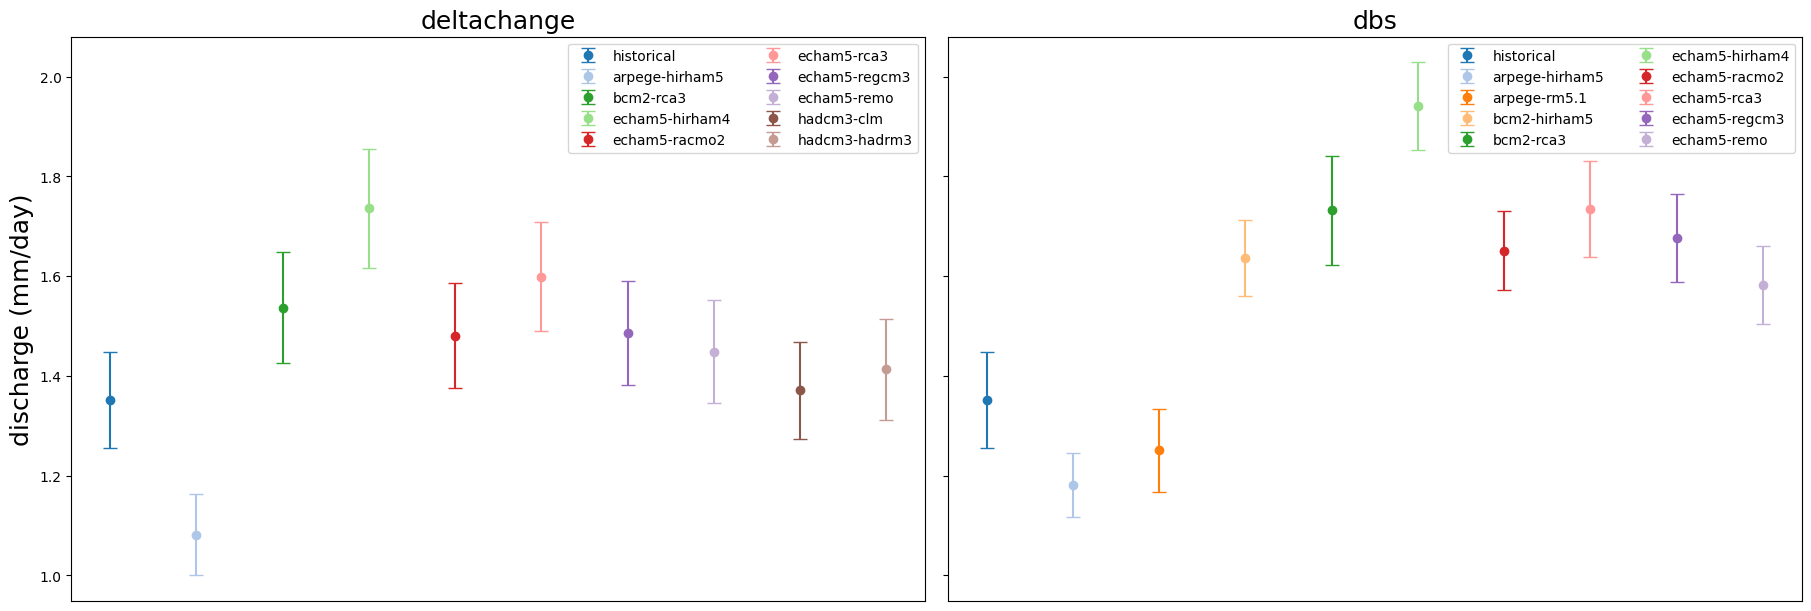

In [79]:
for v in ["t", "p", "q"]:
    fig, axs = plt.subplots(figsize=(18,6), ncols=2, sharey=True, constrained_layout=True)
    axs[0].set_ylabel(f"{variable_names[v]} ({variable_units[v]})", fontsize=18)
    for bias_correction_, ax in zip(["deltachange", "dbs"], axs):
        i = 0
        mm = []
        for bias_correction in ["uncorrected", bias_correction_]:
            for model in models:
                if (bias_correction, model, v) in mean_tree:
                    arr = jnp.ravel(mean_tree[(bias_correction, model, v)])
                    ax.errorbar(
                        i, jnp.mean(arr),
                        yerr=scipy.stats.t.ppf(0.975, arr.shape[0]-1)*jnp.std(arr) / jnp.sqrt(arr.shape[0]),
                        fmt='o', capsize=5, label=model, color=model_to_c[model]
                    )
                    i += 1
                    mm.append(model)

        #ax.set_xlabel(f"Annual mean ({variable_units[v]})", fontsize=18)
        #ax.set_xticks(np.arange(i))
        #ax.set_xticklabels(mm)
        ax.set_xticks([])
        ax.legend(ncols=2)
        ax.set_title(f"{bias_correction}", fontsize=18)

        fig.savefig(f"plots/future/mean_ci_{v}.png")


{('dbs',
  'arpege-hirham5',
  'eact'): Array([1.0731106 , 0.9788129 , 0.9645895 , 1.066843  , 1.1539068 ,
        1.0930882 , 1.0241582 , 1.096519  , 1.158596  , 1.0832071 ,
        1.1627543 , 1.030446  , 1.0172023 , 1.0423365 , 0.9704084 ,
        1.0901096 , 1.1152395 , 0.9548592 , 0.99184763, 1.0719483 ,
        1.1247203 , 1.0257032 , 0.95308715, 0.9357602 , 1.0606071 ,
        0.9603605 , 0.973637  , 0.87836456, 1.0961037 , 0.75339776],      dtype=float32),
 ('dbs',
  'arpege-hirham5',
  'p'): Array([2.0942192, 2.2487671, 2.0579178, 2.06194  , 2.4898355, 2.3967397,
        2.2961643, 2.5570493, 2.4754248, 2.5317261, 2.2990959, 2.6210928,
        2.5028493, 1.9724383, 2.366411 , 1.9819672, 2.4639726, 2.043589 ,
        2.1551232, 2.5069945, 2.6360273, 2.158685 , 2.9775343, 2.219235 ,
        2.8749042, 2.5642467, 2.098137 , 1.4519125, 2.2296438, 1.6510684],      dtype=float32),
 ('dbs',
  'arpege-hirham5',
  'q'): Array([1.0996888 , 1.0962204 , 1.1309575 , 0.9154134 , 1.0677658 ,